In [1]:
import os
import sys
import glob
import pickle
import itertools
import random
import copy

from IPython.display import Image

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.colors import ListedColormap
from scipy.stats import multivariate_normal

import numpy as np
import pandas as pd
from scipy.stats import beta
from scipy.stats import norm

from flowMP import *

random.seed(1234)
%matplotlib inline

In [2]:
def logP_Mondrian_Gaussian_perturbation(indiv_mp,template_mp,stepsize):
    """
    To-do: truncated Gaussian pdf
    """
    if template_mp[1] == None and template_mp[2] == None:
        return 0
    
    # find the dimension and location of first cut in the old_sample
    for _ in range(template_mp[0].shape[0]):
        if template_mp[0][_,1] > template_mp[1][0][_,1]:
            break
    
    dim = _
    pos_template = template_mp[1][0][dim,1]
    pos_indiv = indiv_mp[1][0][dim, 1]
    
    res = norm(pos_template,(template_mp[0][dim,1] - template_mp[0][dim,0])*stepsize).logpdf(pos_indiv)
    
    res += logP_Mondrian_Gaussian_perturbation(indiv_mp[1],template_mp[1],stepsize)
    res += logP_Mondrian_Gaussian_perturbation(indiv_mp[2],template_mp[2],stepsize)
    return res


### function for computing joint probability
def joint_logP_Random_Effect(template_mp, indiv_mp_list, data_list, table, stepsize):
    """
    INPUT:
    template_mp: one mondrian process
    indiv_mp_list: a list of mondrian processes
    data_list: a list of cell*marker np array
    table: +1 -1 0 information
    """
    logP = comp_log_p_prior(template_mp, table, [1 for _ in range(table.shape[1])])
    n_sample = len(data_list)
    for _ in range(n_sample):
        logP += logP_Mondrian_Gaussian_perturbation(indiv_mp_list[_], template_mp, stepsize)
        logP += comp_log_p_sample(indiv_mp_list[_], data_list[_])
    return logP


## a mini MCMC run to initialize Mondrian process with data
def init_mp(theta_space, table, data, n_iter,mcmc_gaussin_std):
    # randomly draw a template mondrian process
    sample = draw_informed_Mondrian(theta_space, table)
    log_p_sample = comp_log_p_sample(sample, pooled_data) + \
                         comp_log_p_prior(sample, table, [1 for _ in range(table.shape[1])])

    for idx in xrange(n_iter):
        new_sample = Mondrian_Gaussian_perturbation(theta_space,sample, mcmc_gaussin_std)
        # perform accept-reject step
        new_log_p_sample = comp_log_p_sample(new_sample, data) + \
                            comp_log_p_prior(new_sample, table, [1 for _ in range(table.shape[1])])

        if new_log_p_sample >=  log_p_sample or \
            np.log(np.random.uniform(low=0, high=1.)) <= new_log_p_sample - log_p_sample:
            sample = new_sample
            log_p_sample = new_log_p_sample
    return sample

## Flow Cytometry Data

Load AML data from 21 samples, 5 of them are healthy (H\*), 16 of them are AML samples (SJ\*).

In [3]:
%%time

# load data into a dictionary of pandas data frames

PATH_DATA = '/extra/disij0/data/flow_cytometry/cytobank/levine_aml/CSV/'
#PATH = '/Users/disiji/Dropbox/current/flow_cytometry/acdc/data/'

user_ids = ['H1','H2','H3','H4','H5','SJ01','SJ02','SJ03','SJ04','SJ05','SJ06','SJ07','SJ08','SJ09','SJ10',\
           'SJ11','SJ12','SJ13','SJ14','SJ15','SJ16']

data_dict = dict()
for id in user_ids:
    print id
    data_path = PATH_DATA + id
    allFiles = glob.glob(data_path + "/*fcsdim_42.csv")
    frame = pd.DataFrame()
    list_ = []
    for file_ in allFiles:
        df = pd.read_csv(file_,index_col=None, header=0)
        list_.append(df)
    data_dict[id] = pd.concat(list_)

H1
H2
H3
H4
H5
SJ01
SJ02
SJ03
SJ04
SJ05
SJ06
SJ07
SJ08
SJ09
SJ10
SJ11
SJ12
SJ13
SJ14
SJ15
SJ16
CPU times: user 4min 17s, sys: 10.5 s, total: 4min 28s
Wall time: 4min 50s


In [4]:
markers = ['HLA-DR','CD19','CD34','CD45','CD47','CD44','CD117','CD123','CD38','CD11b',\
                'CD7','CD15','CD3','CD64','CD33','CD41']
 
print markers
    
PATH_TABLE = '/home/disij/projects/acdc/data/AML_benchmark/'
table = pd.read_csv(PATH_TABLE + 'AML_table.csv', sep=',', header=0, index_col=0)
table = table.fillna(0)
table = table[markers]
print table.shape
print table

cell_type_name2idx = {x:i for i,x in enumerate(table.index)}
cell_type_idx2name = {i:x for i,x in enumerate(table.index)}

['HLA-DR', 'CD19', 'CD34', 'CD45', 'CD47', 'CD44', 'CD117', 'CD123', 'CD38', 'CD11b', 'CD7', 'CD15', 'CD3', 'CD64', 'CD33', 'CD41']
(14, 16)
                        HLA-DR  CD19  CD34  CD45  CD47  CD44  CD117  CD123  \
Basophils                 -1.0    -1    -1   0.0   0.0   0.0    0.0      1   
CD4 T cells               -1.0    -1    -1   0.0   0.0   0.0    0.0     -1   
CD8 T cells               -1.0    -1    -1   0.0   0.0   0.0    0.0     -1   
CD16- NK cells            -1.0    -1    -1   0.0   0.0   0.0    0.0     -1   
CD16+ NK cells            -1.0    -1    -1   0.0   0.0   0.0    0.0     -1   
CD34+CD38+CD123- HSPCs     0.0    -1     1  -1.0   0.0   0.0    0.0     -1   
CD34+CD38+CD123+ HSPCs     0.0    -1     1  -1.0   0.0   0.0    0.0      1   
CD34+CD38lo HSCs           0.0    -1     1  -1.0   0.0   0.0    0.0     -1   
Mature B cells             0.0     1    -1   0.0   0.0   0.0    0.0     -1   
Plasma B cells            -1.0     1    -1   0.0   0.0   0.0    0.0     -1   
P

Now run MCMC to collect posterior samples...

#### Training models for healthy samples individually

In [5]:
f = lambda x: np.arcsinh((x -1.)/5.)
data = [data_dict[_].head(20000).applymap(f)[markers].values for _ in user_ids]

<img src="gating_live_singlet.jpg">

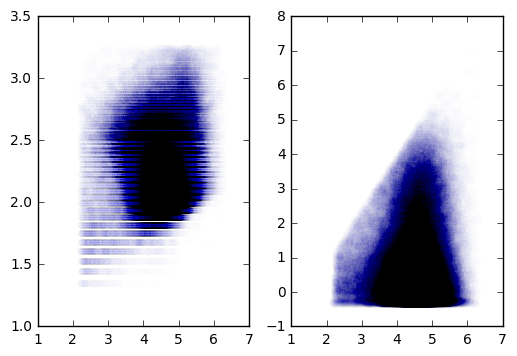

In [6]:
# preprocess data
fig, axarr = plt.subplots(1, 2)
axarr[0].scatter(data_dict['H1']['DNA1'].apply(f),data_dict['H1']['Cell_length'].apply(f),alpha = 0.002)
axarr[1].scatter(data_dict['H1']['DNA1'].apply(f),data_dict['H1']['Viability'].apply(f),alpha = 0.002)
plt.show()

In [7]:
%%time

population_size = [[] for id in range(len(user_ids))]

for id in range(len(user_ids)):
    
    data_subset = data[id]
    n_mcmc_chain = 3
    n_mcmc_sample = 20000
    emp_bounds = np.array([(data_subset[:,i].min(), data_subset[:,i].max()) for i in range(data_subset.shape[1])])

    accepts = [[] for _ in range(n_mcmc_chain)]
    rejects = [[] for _ in range(n_mcmc_chain)]
    logl_accepted_trace = [[] for _ in range(n_mcmc_chain)]
    logl_complete_trace = [[] for _ in range(n_mcmc_chain)]
    Y_predict_accepted_trace = [[] for _ in range(n_mcmc_chain)]
    accuracy_accepted_trace = [[] for _ in range(n_mcmc_chain)]

    for chain in range(n_mcmc_chain):

        print "Drawing Chain %d ..." % chain
        mcmc_gaussin_std = 0.1

        sample = draw_informed_Mondrian(emp_bounds, table)
        log_p_sample = comp_log_p_sample(sample, data_subset)

        accepts[chain].append(sample)
        logl_accepted_trace[chain].append(log_p_sample)
        logl_complete_trace[chain].append(log_p_sample)

        Y_predict = classify_cells(data_subset, sample, table, cell_type_name2idx)
        Y_predict_accepted_trace[chain].append(Y_predict)

        for idx in range(n_mcmc_sample):
            if idx == n_mcmc_sample / 2:
                mcmc_gaussin_std  = mcmc_gaussin_std / 10

            new_sample = Mondrian_Gaussian_perturbation(emp_bounds,sample, mcmc_gaussin_std)
            new_log_p_sample = comp_log_p_sample(new_sample, data_subset) 
            logl_complete_trace[chain].append(new_log_p_sample)

            if new_log_p_sample <  log_p_sample and \
                np.log(np.random.uniform(low=0, high=1.)) > (new_log_p_sample - log_p_sample):
                    rejects[chain].append(new_sample)

            else:                
                sample = new_sample
                log_p_sample = new_log_p_sample
                accepts[chain].append(sample)
                logl_accepted_trace[chain].append(log_p_sample)

                Y_predict = classify_cells(data_subset, sample, table, cell_type_name2idx)
                Y_predict_accepted_trace[chain].append(Y_predict)

            if (idx+1) % 5000 == 0:
                print "Iteration %d, cummulative accepted sample size is %d" %(idx+1, len(accepts[chain]))

    print "Total number of accepted samples: %d" %(sum([len(accepts[chain]) for chain in range(n_mcmc_chain)]))

    # keep the last 2 samples on each chain
    burnt_samples = [i for _ in range(n_mcmc_chain) for i in accepts[_][-2:]]
    burnt_predictions = [None for i in burnt_samples]
    for i in range(len(burnt_samples)):
        burnt_predictions[i] = classify_cells(data_subset, burnt_samples[i], table, cell_type_name2idx)
    # vote
    votes = np.zeros([data_subset.shape[0], table.shape[0]])
    for Y_predict in burnt_predictions:
        for _ in range(len(Y_predict)):
            votes[_,Y_predict[_]] += 1
    Y_predict_majority = np.argmax(votes, axis=1)

    Y_predict_majority = [cell_type_idx2name[_] for _ in Y_predict_majority]
    population_size[id] = [Y_predict_majority.count(_)*1.0 / len(Y_predict_majority) for _ in table.index]
    # 3 chain, 5000 samples

Drawing Chain 0 ...
Iteration 5000, cummulative accepted sample size is 21
Iteration 10000, cummulative accepted sample size is 22
Iteration 15000, cummulative accepted sample size is 58
Iteration 20000, cummulative accepted sample size is 60
Drawing Chain 1 ...
Iteration 5000, cummulative accepted sample size is 26
Iteration 10000, cummulative accepted sample size is 28
Iteration 15000, cummulative accepted sample size is 45
Iteration 20000, cummulative accepted sample size is 46
Drawing Chain 2 ...
Iteration 5000, cummulative accepted sample size is 29
Iteration 10000, cummulative accepted sample size is 29
Iteration 15000, cummulative accepted sample size is 50
Iteration 20000, cummulative accepted sample size is 53
Total number of accepted samples: 159
Drawing Chain 0 ...
Iteration 5000, cummulative accepted sample size is 23
Iteration 10000, cummulative accepted sample size is 24
Iteration 15000, cummulative accepted sample size is 56
Iteration 20000, cummulative accepted sample s

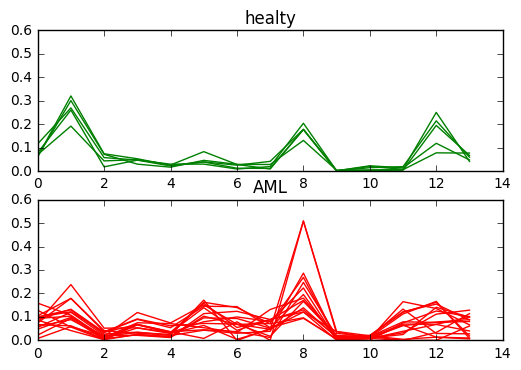

In [8]:
population = np.array(population_size)
fig, axarr = plt.subplots(2, 1,sharey=True)
for id in range(0,5):
    axarr[0].plot(population[id],color = 'g')
axarr[0].set_title('healty')
for id in range(5,21):
    axarr[1].plot(population[id],color = 'r')
axarr[1].set_title('AML')
plt.show()

In [9]:
print population_size

[[0.11695, 0.2702, 0.05845, 0.04845, 0.03055, 0.03085, 0.01, 0.02045, 0.2049, 0.00245, 0.02375, 0.0148, 0.1195, 0.0487], [0.07935, 0.261, 0.0192, 0.04775, 0.02305, 0.0397, 0.01335, 0.01265, 0.1782, 0.00285, 0.0207, 0.0088, 0.251, 0.0424], [0.07145, 0.19265, 0.04445, 0.04995, 0.02705, 0.0839, 0.0294, 0.01005, 0.17825, 0.00185, 0.01565, 0.02, 0.215, 0.06035], [0.0629, 0.30135, 0.07255, 0.03075, 0.0178, 0.04685, 0.02975, 0.0292, 0.13165, 0.0047, 0.0038, 0.00515, 0.1956, 0.06795], [0.06285, 0.32115, 0.07475, 0.05365, 0.0258, 0.04045, 0.02625, 0.04255, 0.17905, 0.0032, 0.0065, 0.00715, 0.0788, 0.07785], [0.02285, 0.094, 0.00385, 0.06645, 0.03355, 0.1394, 0.04295, 0.08825, 0.17035, 0.01535, 0.0219, 0.11965, 0.16235, 0.0191], [0.0562, 0.12005, 0.0214, 0.0217, 0.01245, 0.1031, 0.06815, 0.07225, 0.26855, 0.00295, 0.0165, 0.07925, 0.07675, 0.0807], [0.06745, 0.06225, 0.00665, 0.02475, 0.014, 0.1142, 0.1241, 0.0891, 0.1214, 0.0009, 0.0079, 0.165, 0.13595, 0.06635], [0.04785, 0.0982, 0.0183, 0.033

### Random effect model

#### Training models for healthy samples

In [10]:
data = [data_dict[_].head(20000).applymap(f)[markers].values for _ in ['H1','H2','H3','H4','H5']]

# compute data range 
data_ranges = np.array([[[data[_][:,d].min(),data[_][:,d].max()] \
                        for d in range(len(markers))]
                        for _ in range(len(data))])

theta_space = np.array([[data_ranges[:,d,0].min(), data_ranges[:,d,1].max()] \
                        for d in range(len(markers))])

n_samples = len(data)

In [11]:
%%time

n_mcmc_chain = 10
n_mcmc_sample = 3000
mcmc_gaussin_std = 0.1
random_effect_gaussian_std = 0.5

accepts_template_mp = [[] for _ in range(n_mcmc_chain)]
accepts_indiv_mp_lists = [[[] for i in range(n_samples)] for _ in range(n_mcmc_chain)]
joint_logP = [[] for _ in range(n_mcmc_chain)]

for chain in range(n_mcmc_chain):
    
    mcmc_gaussin_std = 0.1
    
    ### INITIALIZE template_mp AND indivi_mp_list
    print "Initializing template mondrian process with pooled data"
    pooled_data = np.concatenate(data)
    template_mp = init_mp(theta_space, table, pooled_data, 100, mcmc_gaussin_std)
    indiv_mp_list = [np.copy(template_mp) for _ in range(n_samples)] 
    accepts_template_mp[chain].append(template_mp)
    
    if chain % 5 == 0:
        print "Drawing Chain %d ..." % chain
    
    for idx in xrange(n_mcmc_sample):
        
        if idx == n_mcmc_sample / 2:
            mcmc_gaussin_std  = mcmc_gaussin_std / 5
        
        # update indiv mondrian processes of each sample
        for _ in range(n_samples):
            new_sample = Mondrian_Gaussian_perturbation(
                            theta_space,indiv_mp_list[_], mcmc_gaussin_std)
 
            log_p = joint_logP_Random_Effect(template_mp, \
                    [indiv_mp_list[_]],[data[_]], table, random_effect_gaussian_std)
            new_log_p = joint_logP_Random_Effect(template_mp, \
                    [new_sample],[data[_]], table, random_effect_gaussian_std)
        
            
            if new_log_p >  log_p or \
            np.log(np.random.uniform(low=0, high=1.)) < new_log_p - log_p:
                indiv_mp_list[_] = new_sample
                accepts_indiv_mp_lists[chain][_].append(new_sample)
                
                
        # update template mondrian process
        new_sample = Mondrian_Gaussian_perturbation(
                    theta_space, template_mp, mcmc_gaussin_std)
        
        log_p = joint_logP_Random_Effect(template_mp, indiv_mp_list, 
                [np.empty((0,table.shape[1])) for _ in range(n_samples)],\
                table, random_effect_gaussian_std)

        new_log_p = joint_logP_Random_Effect(new_sample, indiv_mp_list, 
                [np.empty((0,table.shape[1])) for _ in range(n_samples)],\
                table, random_effect_gaussian_std)
        
        if new_log_p >  log_p or \
        np.log(np.random.uniform(low=0, high=1.)) < new_log_p - log_p:
            template_mp = new_sample
            accepts_template_mp[chain].append(template_mp)
            
        joint_logP[chain].append(joint_logP_Random_Effect(template_mp, indiv_mp_list, \
                                data, table, random_effect_gaussian_std))

        if (idx + 1) % (n_mcmc_sample/10) == 0:
            print "Drawing Sample %d ..." % (idx + 1)
            print "Accepted proposals of indiv mp, template mp: %d, %d, %d, %d, %d, %d" \
                    % (len(accepts_indiv_mp_lists[chain][0]), \
                       len(accepts_indiv_mp_lists[chain][1]), \
                       len(accepts_indiv_mp_lists[chain][2]), \
                       len(accepts_indiv_mp_lists[chain][3]), \
                       len(accepts_indiv_mp_lists[chain][4]), \
                       len(accepts_template_mp[chain]))               

Initializing template mondrian process with pooled data
Drawing Chain 0 ...
Drawing Sample 300 ...
Accepted proposals of indiv mp, template mp: 9, 6, 6, 10, 6, 80
Drawing Sample 600 ...
Accepted proposals of indiv mp, template mp: 10, 6, 6, 11, 8, 143
Drawing Sample 900 ...
Accepted proposals of indiv mp, template mp: 10, 6, 7, 11, 9, 198
Drawing Sample 1200 ...
Accepted proposals of indiv mp, template mp: 10, 6, 7, 14, 12, 255
Drawing Sample 1500 ...
Accepted proposals of indiv mp, template mp: 11, 6, 7, 15, 13, 310
Drawing Sample 1800 ...
Accepted proposals of indiv mp, template mp: 22, 14, 18, 21, 19, 547
Drawing Sample 2100 ...
Accepted proposals of indiv mp, template mp: 24, 15, 22, 22, 23, 783
Drawing Sample 2400 ...
Accepted proposals of indiv mp, template mp: 24, 15, 23, 27, 26, 1011
Drawing Sample 2700 ...
Accepted proposals of indiv mp, template mp: 25, 16, 23, 28, 30, 1239
Drawing Sample 3000 ...
Accepted proposals of indiv mp, template mp: 25, 17, 25, 28, 30, 1484
Initializ

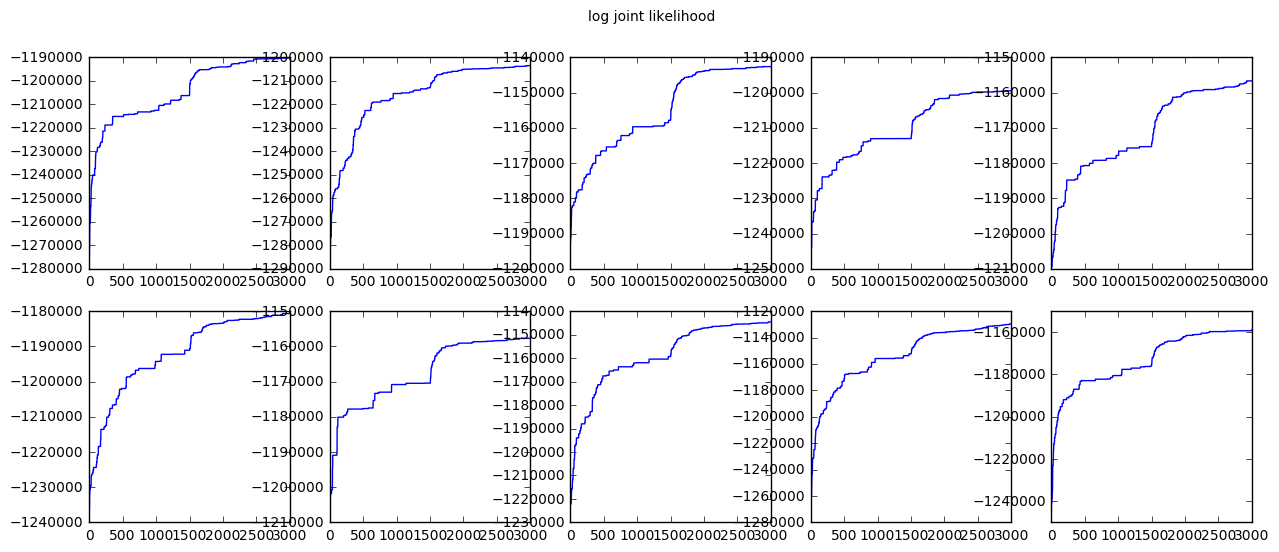

In [12]:
fig, axarr = plt.subplots(n_mcmc_chain / 5, 5, figsize=(15,6 * n_mcmc_chain / 10))
for i in range(n_mcmc_chain):
    axarr[i/5,i%5].plot(joint_logP[i])
fig.suptitle("log joint likelihood")
plt.show()

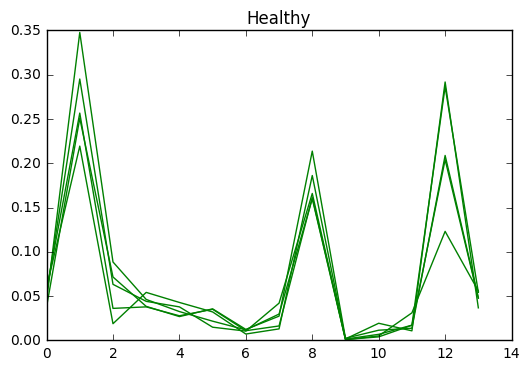

In [13]:
temp_mp_H = copy.deepcopy(accepts_template_mp)
indiv_mp_list_H = copy.deepcopy(accepts_indiv_mp_lists)
population_size_H = [None for _ in range(n_samples)]

for id in range(n_samples):
    data_subset = data[id]
    burnt_samples = [i for _ in range(n_mcmc_chain) for i in \
                     accepts_indiv_mp_lists[_][id][-2:]]
    burnt_predictions = [None for i in burnt_samples]
    for i in range(len(burnt_samples)):
        burnt_predictions[i] = classify_cells(data_subset, burnt_samples[i], \
                                              table, cell_type_name2idx)
    votes = np.zeros([data_subset.shape[0], table.shape[0]])
    for Y_predict in burnt_predictions:
        for _ in range(len(Y_predict)):
            votes[_,Y_predict[_]] += 1
    Y_predict_majority = np.argmax(votes, axis=1)

    Y_predict_majority = [cell_type_idx2name[_] for _ in Y_predict_majority]
    population_size_H[id] = [Y_predict_majority.count(_)*1.0 / len(Y_predict_majority) \
                             for _ in table.index]

for id in range(n_samples):
    plt.plot(population_size_H[id],color = 'g')
plt.title('Healthy')
plt.show()

In [45]:
print population_size_H

[[0.03775, 0.2509, 0.07165, 0.03845, 0.02695, 0.03565, 0.01245, 0.02745, 0.21375, 0.00245, 0.01155, 0.0138, 0.20885, 0.04835], [0.05695, 0.2567, 0.0362, 0.0379, 0.02785, 0.0352, 0.011, 0.01635, 0.1613, 0.0017, 0.0194, 0.01085, 0.2918, 0.0368], [0.05945, 0.2194, 0.0189, 0.05425, 0.0429, 0.0322, 0.00725, 0.01305, 0.1862, 0.00155, 0.0069, 0.01725, 0.28645, 0.05425], [0.05195, 0.29515, 0.06335, 0.04415, 0.0379, 0.01495, 0.01055, 0.0421, 0.16595, 0.001, 0.00405, 0.01715, 0.2041, 0.04765], [0.0451, 0.34775, 0.0886, 0.0463, 0.0326, 0.02175, 0.01195, 0.0298, 0.16005, 0.00085, 0.0051, 0.03115, 0.12315, 0.05585]]


#### Training models for unhealthy samples

In [14]:
data = data = [data_dict[_].head(20000).applymap(f)[markers].values for _ in ['SJ01','SJ02',\
            'SJ03','SJ04','SJ05','SJ06','SJ07','SJ08','SJ09','SJ10',\
            'SJ11','SJ12','SJ13','SJ14','SJ15','SJ16']]
 
# compute data range 
data_ranges = np.array([[[data[_][:,d].min(),data[_][:,d].max()] \
                        for d in range(len(markers))]
                        for _ in range(len(data))])

theta_space = np.array([[data_ranges[:,d,0].min(), data_ranges[:,d,1].max()] \
                        for d in range(len(markers))])

n_samples = len(data)

In [15]:
%%time

n_mcmc_chain = 10
n_mcmc_sample = 3000
mcmc_gaussin_std = 0.1
random_effect_gaussian_std = 0.5

accepts_template_mp = [[] for _ in range(n_mcmc_chain)]
accepts_indiv_mp_lists = [[[] for i in range(n_samples)] for _ in range(n_mcmc_chain)]
joint_logP = [[] for _ in range(n_mcmc_chain)]

for chain in range(n_mcmc_chain):
    
    mcmc_gaussin_std = 0.1
    
    ### INITIALIZE template_mp AND indivi_mp_list
    print "Initializing template mondrian process with pooled data"
    pooled_data = np.concatenate(data)
    template_mp = init_mp(theta_space, table, pooled_data, 100, mcmc_gaussin_std)
    indiv_mp_list = [np.copy(template_mp) for _ in range(n_samples)] 
    accepts_template_mp[chain].append(template_mp)
    
    if chain % 5 == 0:
        print "Drawing Chain %d ..." % chain
    
    for idx in xrange(n_mcmc_sample):
        
        if idx == n_mcmc_sample / 2:
            mcmc_gaussin_std  = mcmc_gaussin_std / 5
        
        # update indiv mondrian processes of each sample
        for _ in range(n_samples):
            new_sample = Mondrian_Gaussian_perturbation(
                            theta_space,indiv_mp_list[_], mcmc_gaussin_std)
 
            log_p = joint_logP_Random_Effect(template_mp, \
                    [indiv_mp_list[_]],[data[_]], table, random_effect_gaussian_std)
            new_log_p = joint_logP_Random_Effect(template_mp, \
                    [new_sample],[data[_]], table, random_effect_gaussian_std)
        
            
            if new_log_p >  log_p or \
            np.log(np.random.uniform(low=0, high=1.)) < new_log_p - log_p:
                indiv_mp_list[_] = new_sample
                accepts_indiv_mp_lists[chain][_].append(new_sample)
                
                
        # update template mondrian process
        new_sample = Mondrian_Gaussian_perturbation(
                    theta_space, template_mp, mcmc_gaussin_std)
        
        log_p = joint_logP_Random_Effect(template_mp, indiv_mp_list, 
                [np.empty((0,table.shape[1])) for _ in range(n_samples)],\
                table, random_effect_gaussian_std)

        new_log_p = joint_logP_Random_Effect(new_sample, indiv_mp_list, 
                [np.empty((0,table.shape[1])) for _ in range(n_samples)],\
                table, random_effect_gaussian_std)
        
        if new_log_p >  log_p or \
        np.log(np.random.uniform(low=0, high=1.)) < new_log_p - log_p:
            template_mp = new_sample
            accepts_template_mp[chain].append(template_mp)
            
        joint_logP[chain].append(joint_logP_Random_Effect(template_mp, indiv_mp_list, \
                                data, table, random_effect_gaussian_std))     
            
        if (idx + 1) % (n_mcmc_sample/10) == 0:
            print "Drawing Sample %d ..." % (idx + 1)
            print "Accepted proposals of indiv mp, template mp: %d, %d, %d, %d, %d, %d" \
                    % (len(accepts_indiv_mp_lists[chain][0]), \
                       len(accepts_indiv_mp_lists[chain][1]), \
                       len(accepts_indiv_mp_lists[chain][2]), \
                       len(accepts_indiv_mp_lists[chain][3]), \
                       len(accepts_indiv_mp_lists[chain][4]), \
                       len(accepts_template_mp[chain]))  

temp_mp_SJ = copy.deepcopy(accepts_template_mp)
indiv_mp_list_SJ = copy.deepcopy(accepts_indiv_mp_lists)

Initializing template mondrian process with pooled data
Drawing Chain 0 ...
Drawing Sample 300 ...
Accepted proposals of indiv mp, template mp: 6, 14, 7, 7, 7, 32
Drawing Sample 600 ...
Accepted proposals of indiv mp, template mp: 8, 16, 8, 9, 9, 62
Drawing Sample 900 ...
Accepted proposals of indiv mp, template mp: 8, 18, 14, 10, 9, 80
Drawing Sample 1200 ...
Accepted proposals of indiv mp, template mp: 8, 18, 14, 10, 11, 112
Drawing Sample 1500 ...
Accepted proposals of indiv mp, template mp: 9, 18, 16, 10, 11, 132
Drawing Sample 1800 ...
Accepted proposals of indiv mp, template mp: 18, 25, 29, 18, 19, 349
Drawing Sample 2100 ...
Accepted proposals of indiv mp, template mp: 26, 27, 33, 19, 20, 575
Drawing Sample 2400 ...
Accepted proposals of indiv mp, template mp: 27, 30, 33, 20, 24, 785
Drawing Sample 2700 ...
Accepted proposals of indiv mp, template mp: 27, 37, 35, 24, 24, 988
Drawing Sample 3000 ...
Accepted proposals of indiv mp, template mp: 27, 38, 35, 25, 25, 1199
Initializin

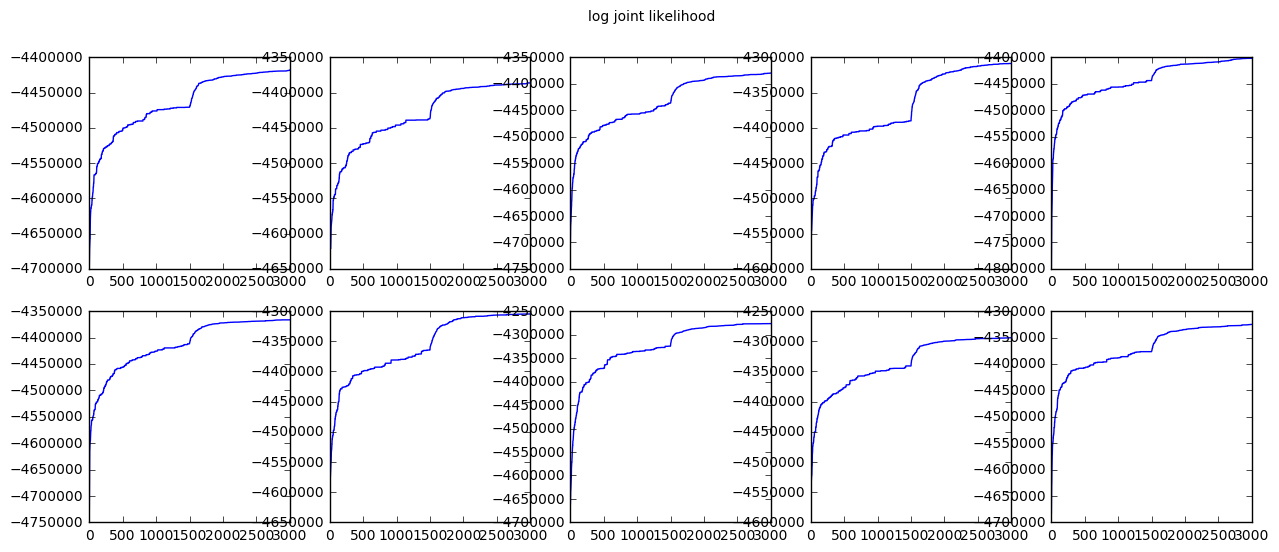

In [16]:
fig, axarr = plt.subplots(n_mcmc_chain / 5, 5, figsize=(15,6 * n_mcmc_chain / 10))
for i in range(n_mcmc_chain):
    axarr[i/5,i%5].plot(joint_logP[i])
fig.suptitle("log joint likelihood")
plt.show()

In [52]:
%%time

n_mcmc_chain = 10
n_mcmc_sample = 300
random_effect_gaussian_std = 0.5
mcmc_gaussin_std = mcmc_gaussin_std / 2


for chain in range(n_mcmc_chain):
    
    ### INITIALIZE template_mp AND indivi_mp_list
    template_mp = accepts_template_mp[chain][-1]
    indiv_mp_list = [accepts_indiv_mp_lists[chain][id][-1] for id in range(n_samples)]
    
    if chain % 5 == 0:
        print "Drawing Chain %d ..." % chain
    
    for idx in xrange(n_mcmc_sample):
        
        # update indiv mondrian processes of each sample
        for _ in range(n_samples):
            new_sample = Mondrian_Gaussian_perturbation(
                            theta_space,indiv_mp_list[_], mcmc_gaussin_std)
 
            log_p = joint_logP_Random_Effect(template_mp, \
                    [indiv_mp_list[_]],[data[_]], table, random_effect_gaussian_std)
            new_log_p = joint_logP_Random_Effect(template_mp, \
                    [new_sample],[data[_]], table, random_effect_gaussian_std)
        
            
            if new_log_p >  log_p or \
            np.log(np.random.uniform(low=0, high=1.)) < new_log_p - log_p:
                indiv_mp_list[_] = new_sample
                accepts_indiv_mp_lists[chain][_].append(new_sample)
                
                
        # update template mondrian process
        new_sample = Mondrian_Gaussian_perturbation(
                    theta_space, template_mp, mcmc_gaussin_std)
        
        log_p = joint_logP_Random_Effect(template_mp, indiv_mp_list, 
                [np.empty((0,table.shape[1])) for _ in range(n_samples)],\
                table, random_effect_gaussian_std)

        new_log_p = joint_logP_Random_Effect(new_sample, indiv_mp_list, 
                [np.empty((0,table.shape[1])) for _ in range(n_samples)],\
                table, random_effect_gaussian_std)
        
        if new_log_p >  log_p or \
        np.log(np.random.uniform(low=0, high=1.)) < new_log_p - log_p:
            template_mp = new_sample
            accepts_template_mp[chain].append(template_mp)
            
        joint_logP[chain].append(joint_logP_Random_Effect(template_mp, indiv_mp_list, \
                                data, table, random_effect_gaussian_std))     
            
        if (idx + 1) % (n_mcmc_sample/10) == 0:
            print "Drawing Sample %d ..." % (idx + 1)
            print "Accepted proposals of indiv mp, template mp: %d, %d, %d, %d, %d, %d" \
                    % (len(accepts_indiv_mp_lists[chain][0]), \
                       len(accepts_indiv_mp_lists[chain][1]), \
                       len(accepts_indiv_mp_lists[chain][2]), \
                       len(accepts_indiv_mp_lists[chain][3]), \
                       len(accepts_indiv_mp_lists[chain][4]), \
                       len(accepts_template_mp[chain]))  

Initializing template mondrian process with pooled data
Drawing Chain 0 ...
Drawing Sample 50 ...
Accepted proposals of indiv mp, template mp: 27, 39, 35, 27, 25, 1242
Drawing Sample 100 ...
Accepted proposals of indiv mp, template mp: 28, 41, 36, 27, 25, 1283
Drawing Sample 150 ...
Accepted proposals of indiv mp, template mp: 29, 43, 38, 27, 25, 1329
Drawing Sample 200 ...
Accepted proposals of indiv mp, template mp: 29, 44, 41, 27, 25, 1375
Drawing Sample 250 ...
Accepted proposals of indiv mp, template mp: 30, 45, 42, 27, 25, 1418
Drawing Sample 300 ...
Accepted proposals of indiv mp, template mp: 31, 46, 42, 27, 26, 1462
Drawing Sample 350 ...
Accepted proposals of indiv mp, template mp: 31, 47, 42, 27, 26, 1503
Drawing Sample 400 ...
Accepted proposals of indiv mp, template mp: 31, 47, 42, 27, 27, 1547
Drawing Sample 450 ...
Accepted proposals of indiv mp, template mp: 33, 48, 42, 27, 27, 1594
Drawing Sample 500 ...
Accepted proposals of indiv mp, template mp: 33, 48, 42, 27, 27, 

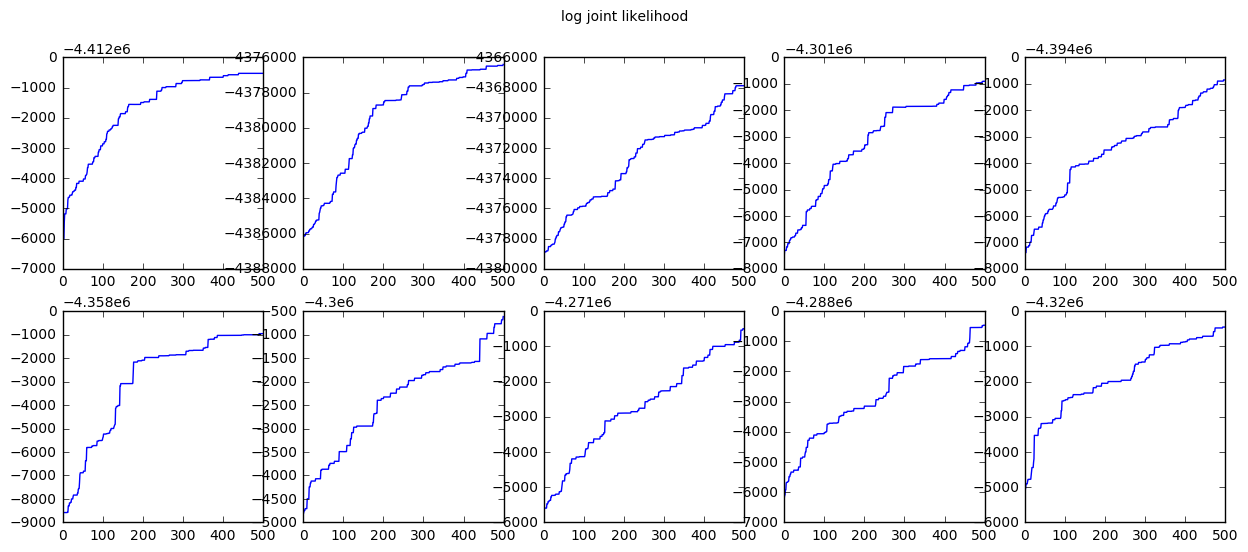

In [53]:
fig, axarr = plt.subplots(n_mcmc_chain / 5, 5, figsize=(15,6 * n_mcmc_chain / 10))
for i in range(n_mcmc_chain):
    axarr[i/5,i%5].plot(joint_logP[i])
fig.suptitle("log joint likelihood")
plt.show()

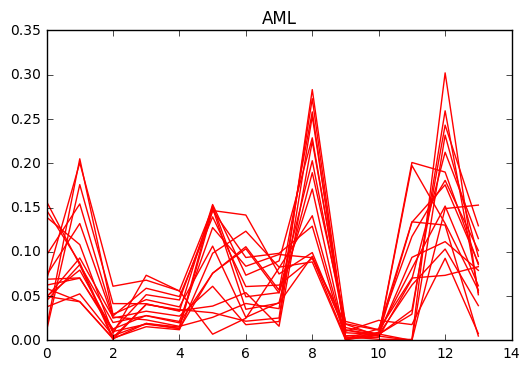

In [54]:
population_size_SJ = [None for _ in range(n_samples)]

for id in range(n_samples):
    data_subset = data[id]
    burnt_samples = [i for _ in range(n_mcmc_chain) for i in \
                     accepts_indiv_mp_lists[_][id][-1:]]
    burnt_predictions = [None for i in burnt_samples]
    for i in range(len(burnt_samples)):
        burnt_predictions[i] = classify_cells(data_subset, burnt_samples[i], \
                                              table, cell_type_name2idx)
    votes = np.zeros([data_subset.shape[0], table.shape[0]])
    for Y_predict in burnt_predictions:
        for _ in range(len(Y_predict)):
            votes[_,Y_predict[_]] += 1
    Y_predict_majority = np.argmax(votes, axis=1)

    Y_predict_majority = [cell_type_idx2name[_] for _ in Y_predict_majority]
    population_size_SJ[id] = [Y_predict_majority.count(_)*1.0 / len(Y_predict_majority) \
                             for _ in table.index]

for id in range(n_samples):
    plt.plot(population_size_SJ[id],color = 'r')
plt.title('AML')
plt.show()

In [70]:
%%time

n_mcmc_chain = 10
n_mcmc_sample = 100
random_effect_gaussian_std = 0.5
mcmc_gaussin_std = mcmc_gaussin_std / 5


for chain in range(n_mcmc_chain):
    
    ### INITIALIZE template_mp AND indivi_mp_list
    template_mp = accepts_template_mp[chain][-1]
    indiv_mp_list = [accepts_indiv_mp_lists[chain][id][-1] for id in range(n_samples)]
    
    if chain % 5 == 0:
        print "Drawing Chain %d ..." % chain
    
    for idx in xrange(n_mcmc_sample):
        
        # update indiv mondrian processes of each sample
        for _ in range(n_samples):
            new_sample = Mondrian_Gaussian_perturbation(
                            theta_space,indiv_mp_list[_], mcmc_gaussin_std)
 
            log_p = joint_logP_Random_Effect(template_mp, \
                    [indiv_mp_list[_]],[data[_]], table, random_effect_gaussian_std)
            new_log_p = joint_logP_Random_Effect(template_mp, \
                    [new_sample],[data[_]], table, random_effect_gaussian_std)
        
            
            if new_log_p >  log_p or \
            np.log(np.random.uniform(low=0, high=1.)) < new_log_p - log_p:
                indiv_mp_list[_] = new_sample
                accepts_indiv_mp_lists[chain][_].append(new_sample)
                
                
        # update template mondrian process
        new_sample = Mondrian_Gaussian_perturbation(
                    theta_space, template_mp, mcmc_gaussin_std)
        
        log_p = joint_logP_Random_Effect(template_mp, indiv_mp_list, 
                [np.empty((0,table.shape[1])) for _ in range(n_samples)],\
                table, random_effect_gaussian_std)

        new_log_p = joint_logP_Random_Effect(new_sample, indiv_mp_list, 
                [np.empty((0,table.shape[1])) for _ in range(n_samples)],\
                table, random_effect_gaussian_std)
        
        if new_log_p >  log_p or \
        np.log(np.random.uniform(low=0, high=1.)) < new_log_p - log_p:
            template_mp = new_sample
            accepts_template_mp[chain].append(template_mp)
            
        joint_logP[chain].append(joint_logP_Random_Effect(template_mp, indiv_mp_list, \
                                data, table, random_effect_gaussian_std))     
            
        if (idx + 1) % (n_mcmc_sample/10) == 0:
            print "Drawing Sample %d ..." % (idx + 1)
            print "Accepted proposals of indiv mp, template mp: %d, %d, %d, %d, %d, %d" \
                    % (len(accepts_indiv_mp_lists[chain][0]), \
                       len(accepts_indiv_mp_lists[chain][1]), \
                       len(accepts_indiv_mp_lists[chain][2]), \
                       len(accepts_indiv_mp_lists[chain][3]), \
                       len(accepts_indiv_mp_lists[chain][4]), \
                       len(accepts_template_mp[chain]))  

Initializing template mondrian process with pooled data
Drawing Chain 0 ...
Drawing Sample 10 ...
Accepted proposals of indiv mp, template mp: 37, 48, 44, 29, 30, 1644
Drawing Sample 20 ...
Accepted proposals of indiv mp, template mp: 40, 48, 44, 29, 30, 1654
Drawing Sample 30 ...
Accepted proposals of indiv mp, template mp: 40, 49, 44, 30, 30, 1664
Drawing Sample 40 ...
Accepted proposals of indiv mp, template mp: 41, 49, 44, 31, 30, 1674
Drawing Sample 50 ...
Accepted proposals of indiv mp, template mp: 42, 49, 44, 32, 30, 1684
Drawing Sample 60 ...
Accepted proposals of indiv mp, template mp: 42, 49, 44, 33, 30, 1694
Drawing Sample 70 ...
Accepted proposals of indiv mp, template mp: 42, 51, 45, 33, 30, 1704
Drawing Sample 80 ...
Accepted proposals of indiv mp, template mp: 44, 51, 45, 33, 30, 1714
Drawing Sample 90 ...
Accepted proposals of indiv mp, template mp: 46, 51, 45, 33, 31, 1724
Drawing Sample 100 ...
Accepted proposals of indiv mp, template mp: 46, 51, 45, 34, 31, 1734
Ini

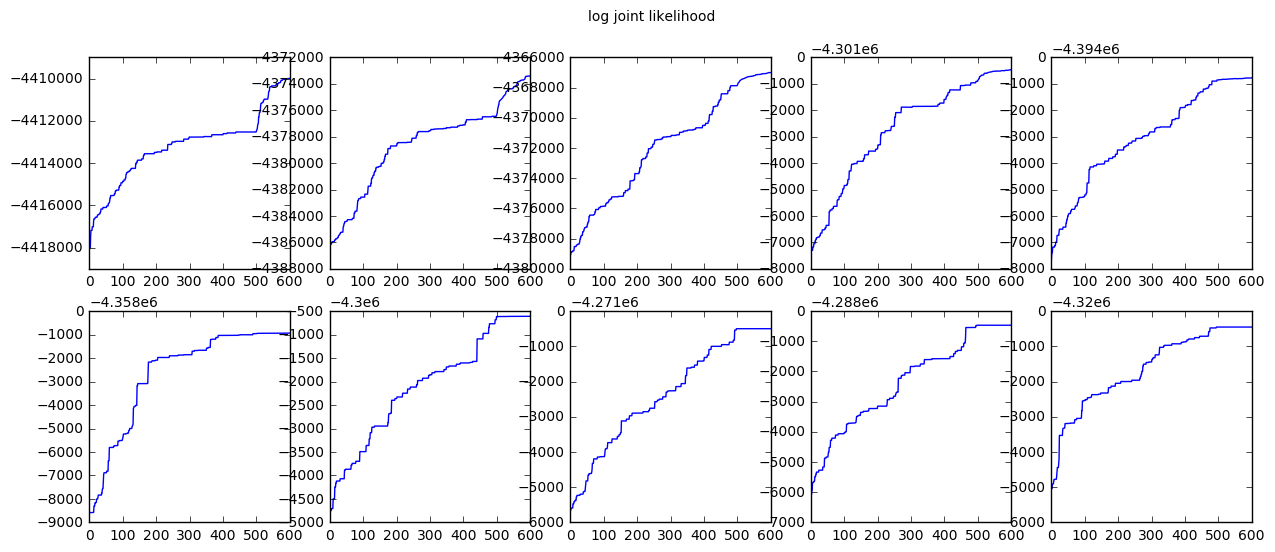

In [71]:
fig, axarr = plt.subplots(n_mcmc_chain / 5, 5, figsize=(15,6 * n_mcmc_chain / 10))
for i in range(n_mcmc_chain):
    axarr[i/5,i%5].plot(joint_logP[i])
fig.suptitle("log joint likelihood")
plt.show()

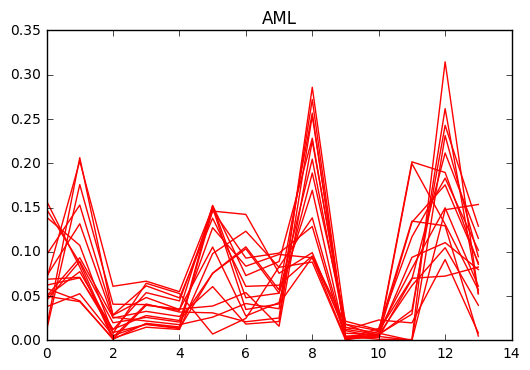

In [72]:
population_size_SJ = [None for _ in range(n_samples)]

for id in range(n_samples):
    data_subset = data[id]
    burnt_samples = [i for _ in range(n_mcmc_chain) for i in \
                     accepts_indiv_mp_lists[_][id][-1:]]
    burnt_predictions = [None for i in burnt_samples]
    for i in range(len(burnt_samples)):
        burnt_predictions[i] = classify_cells(data_subset, burnt_samples[i], \
                                              table, cell_type_name2idx)
    votes = np.zeros([data_subset.shape[0], table.shape[0]])
    for Y_predict in burnt_predictions:
        for _ in range(len(Y_predict)):
            votes[_,Y_predict[_]] += 1
    Y_predict_majority = np.argmax(votes, axis=1)

    Y_predict_majority = [cell_type_idx2name[_] for _ in Y_predict_majority]
    population_size_SJ[id] = [Y_predict_majority.count(_)*1.0 / len(Y_predict_majority) \
                             for _ in table.index]

for id in range(n_samples):
    plt.plot(population_size_SJ[id],color = 'r')
plt.title('AML')
plt.show()

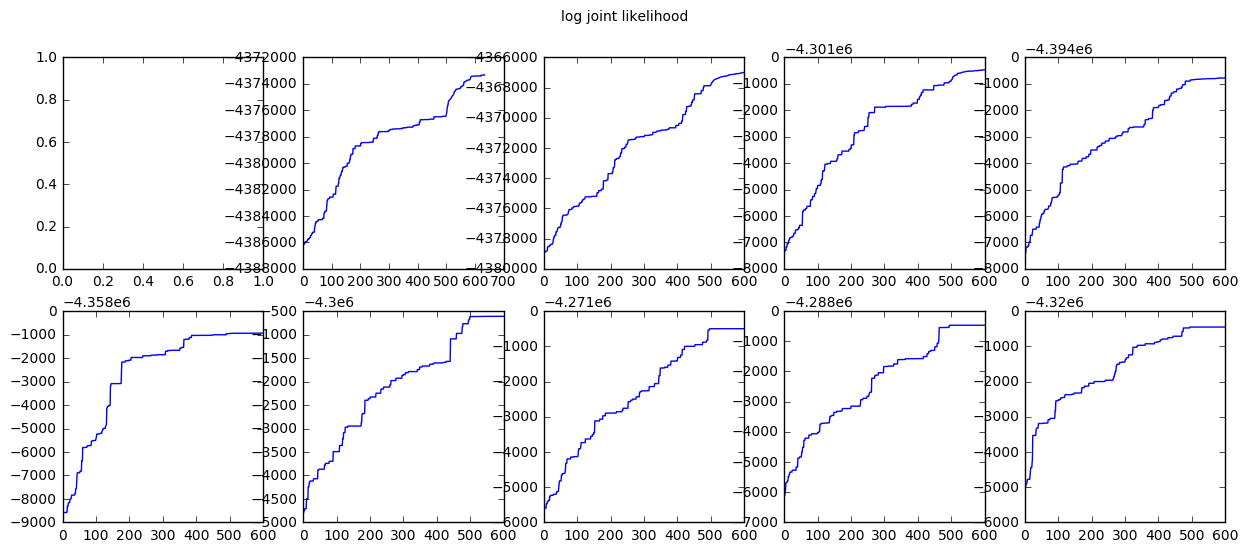

In [110]:
fig, axarr = plt.subplots(n_mcmc_chain / 5, 5, figsize=(15,6 * n_mcmc_chain / 10))
for i in range(1,n_mcmc_chain):
    axarr[i/5,i%5].plot(joint_logP[i])
fig.suptitle("log joint likelihood")
plt.show()

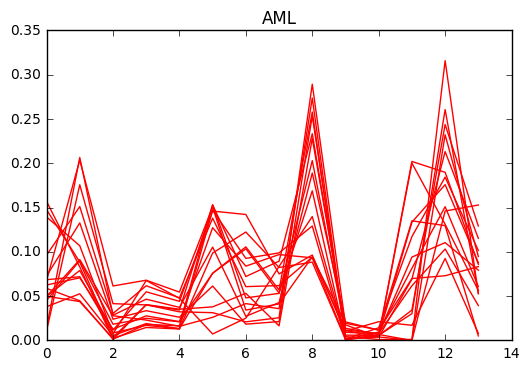

In [111]:
population_size_SJ = [None for _ in range(n_samples)]

for id in range(n_samples):
    data_subset = data[id]
    burnt_samples = [i for _ in range(n_mcmc_chain) for i in \
                     accepts_indiv_mp_lists[_][id][-1:]]
    burnt_predictions = [None for i in burnt_samples]
    for i in range(len(burnt_samples)):
        burnt_predictions[i] = classify_cells(data_subset, burnt_samples[i], \
                                              table, cell_type_name2idx)
    votes = np.zeros([data_subset.shape[0], table.shape[0]])
    for Y_predict in burnt_predictions:
        for _ in range(len(Y_predict)):
            votes[_,Y_predict[_]] += 1
    Y_predict_majority = np.argmax(votes, axis=1)

    Y_predict_majority = [cell_type_idx2name[_] for _ in Y_predict_majority]
    population_size_SJ[id] = [Y_predict_majority.count(_)*1.0 / len(Y_predict_majority) \
                             for _ in table.index]

for id in range(n_samples):
    plt.plot(population_size_SJ[id],color = 'r')
plt.title('AML')
plt.show()

In [112]:
temp_mp_SJ = copy.deepcopy(accepts_template_mp)
indiv_mp_list_SJ = copy.deepcopy(accepts_indiv_mp_lists)

In [113]:
print population_size_SJ

[[0.0588, 0.0448, 0.0015, 0.01805, 0.01655, 0.15305, 0.04805, 0.05315, 0.20305, 0.0112, 0.00405, 0.2002, 0.1311, 0.05645], [0.0452, 0.09025, 0.01835, 0.025, 0.02105, 0.07585, 0.10565, 0.057, 0.2579, 0.0011, 0.00945, 0.08145, 0.151, 0.06075], [0.04995, 0.0439, 0.0023, 0.01465, 0.01295, 0.09865, 0.1224, 0.0824, 0.0884, 0.0011, 0.0054, 0.2021, 0.18985, 0.08595], [0.0381, 0.05265, 0.0055, 0.01905, 0.01335, 0.1471, 0.09265, 0.09885, 0.1292, 0.00045, 0.006, 0.1335, 0.1759, 0.0877], [0.0497, 0.0913, 0.0279, 0.023, 0.01595, 0.0261, 0.0416, 0.03585, 0.27365, 0.00215, 0.00555, 0.0343, 0.24375, 0.1292], [0.07285, 0.1327, 0.02395, 0.0336, 0.0262, 0.0614, 0.0184, 0.0213, 0.25355, 0.00595, 0.0058, 0.03025, 0.2606, 0.05345], [0.0626, 0.0707, 0.0127, 0.02775, 0.02125, 0.1273, 0.0839, 0.09695, 0.0933, 0.00205, 0.00375, 0.06925, 0.2132, 0.1153], [0.1476, 0.08855, 0.0033, 0.0403, 0.0323, 0.03135, 0.021, 0.02565, 0.2893, 0.0176, 0.00395, 0.0001, 0.1461, 0.1529], [0.13945, 0.1069, 0.0075, 0.06765, 0.0476, 

#### compare size of subpopulations in healthy and AML individuals

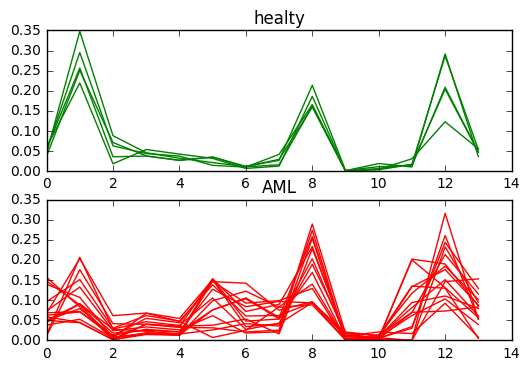

In [122]:
fig, axarr = plt.subplots(2, 1,sharey=True)
for id in range(0,5):
    axarr[0].plot(population_size_H[id],color = 'g')
axarr[0].set_title('healty')
for id in range(0,16):
    axarr[1].plot(population_size_SJ[id],color = 'r')
axarr[1].set_title('AML')
plt.show()

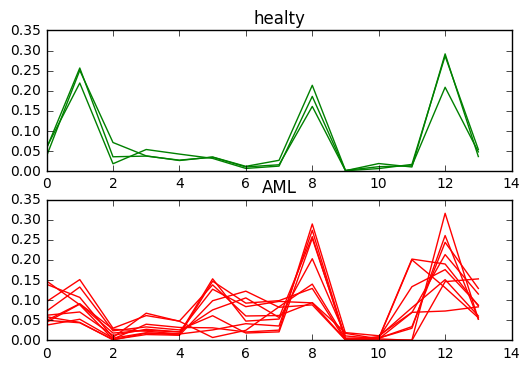

In [124]:
fig, axarr = plt.subplots(2, 1,sharey=True)
for id in range(0,3):
    axarr[0].plot(population_size_H[id],color = 'g')
axarr[0].set_title('healty')
for id in range(0,10):
    axarr[1].plot(population_size_SJ[id],color = 'r')
axarr[1].set_title('AML')
plt.show()

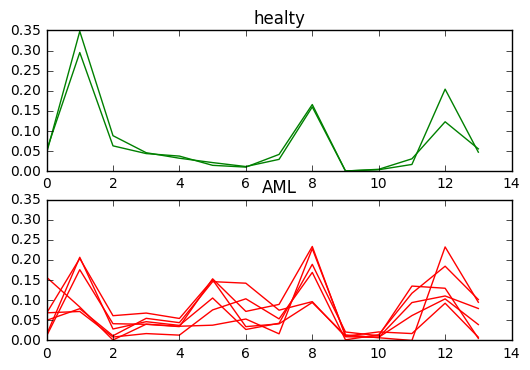

In [138]:
fig, axarr = plt.subplots(2, 1,sharey=True)
for id in range(3,5):
    axarr[0].plot(population_size_H[id],color = 'g')
axarr[0].set_title('healty')
for id in range(10,16):
    axarr[1].plot(population_size_SJ[id],color = 'r')
axarr[1].set_title('AML')
plt.show()

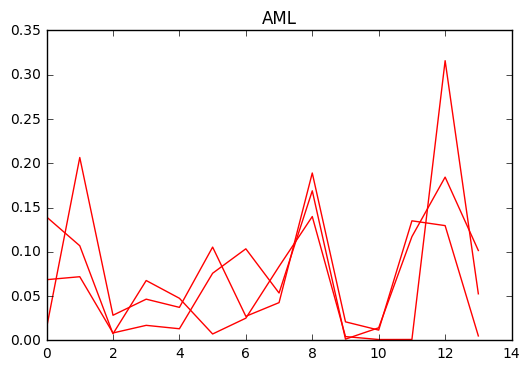

In [168]:
for id in [8,13,15]:
    plt.plot(population_size_SJ[id],color = 'r')
plt.title('AML')
plt.show()

In [216]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
X = np.array(population_size_H  + population_size_SJ)
Y = np.array([0]*5  + [1]*16)
models = []

predict_prob = []
for train, test in loo.split(X,Y):
    train_X = X[train]
    train_Y = Y[train]
    test_X = X[test]
    test_Y = Y[test]
    logreg = linear_model.LogisticRegression(C=1e5)
    logreg.fit(train_X, train_Y)
    test_Y_predict = logreg.predict(test_X)
    print test_Y_predict
    models.append(logreg)
    predict_prob.append(logreg.predict_proba(test_X)[0][0])

[0]
[0]
[0]
[0]
[0]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


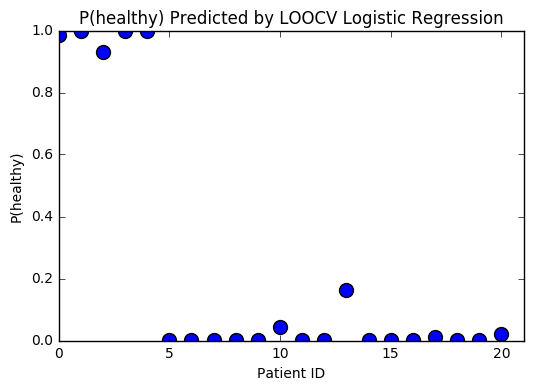

In [243]:
plt.scatter(range(21),predict_prob,s = 100)
plt.xlim(0, 21)
plt.ylim(0, 1)
plt.xlabel('Patient ID')
plt.ylabel('P(healthy)')
plt.title('P(healthy) Predicted by LOOCV Logistic Regression')

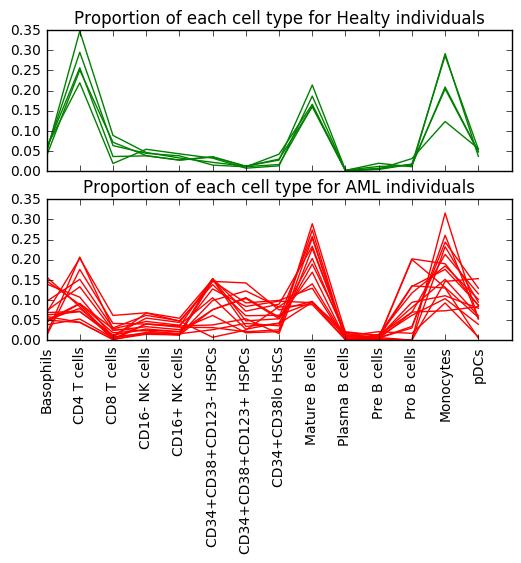

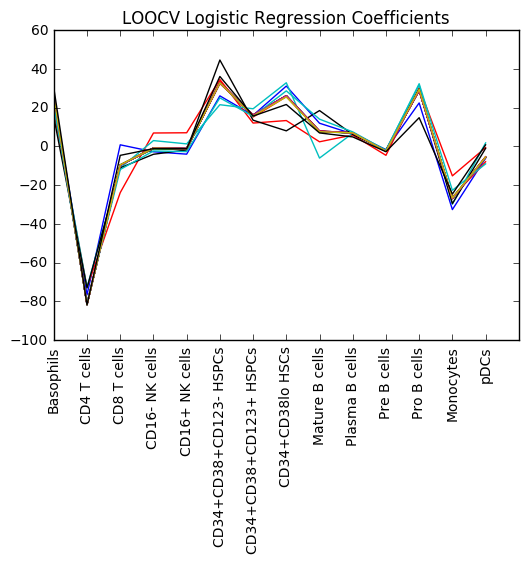

In [211]:
cell_types = [cell_type_idx2name[i] for i in range(14)]

fig, axarr = plt.subplots(2, 1,sharey=True, sharex = True)
for id in range(5):
    axarr[0].plot(population_size_H[id],color = 'g')
axarr[0].set_title('Proportion of each cell type for Healty individuals')
for id in range(16):
    axarr[1].plot(population_size_SJ[id],color = 'r')
axarr[1].set_title('Proportion of each cell type for AML individuals')

plt.xticks(range(14),cell_types,rotation = 90)
plt.show()

for i in range(21):
    plt.plot(models[i].coef_[0])
plt.title('LOOCV Logistic Regression Coefficients')
plt.xticks(range(14),cell_types,rotation = 90)
plt.show()